# CM Credits onderzoeksvraag 2.

In this notebook we will work on answering our 2nd research question. This question is one of our own choice based on an extra dataset we received about previous applications for a loan.

Our question is the following: Is it possible to use the Data to predict if an application is approved or not.

within the answer of our question we will split the 4 possibles values in our target column: NAME_CONTRACT_STATUS which consist of the following values:
- Approved
- Refused
- Cancelled
- Unused offer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Previous application data.

This will be the data we are using:

In [2]:
prev_data = pd.read_csv("src/previous_application.csv",sep=",", encoding='cp1252', index_col=0)
prev_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
SK_ID_PREV,,,,,,,,,,,,,,,,,,,,,
2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


# Data understanding.

Firstly lets take a look at what the columms mean.

In [3]:
# Read the column descriptions from the CSV file
col_desc = pd.read_csv("src/columns_description.csv", sep=",", encoding='cp1252', index_col=0)

# only keep all description from the previous_application dataset
col_desc = col_desc[col_desc['Table'] == "previous_application.csv"]
col_desc = col_desc.drop("Table", axis=1)

# delete double index
col_desc.set_index("Row", inplace=True)

col_desc

,Description,Special
Row,,
SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
SK_ID_CURR,ID of loan in our sample,hashed
NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa...",NaN
AMT_ANNUITY,Annuity of previous application,NaN
AMT_APPLICATION,For how much credit did client ask on the prev...,NaN
AMT_CREDIT,Final credit amount on the previous applicatio...,NaN
AMT_DOWN_PAYMENT,Down payment on the previous application,NaN
AMT_GOODS_PRICE,Goods price of good that client asked for (if ...,NaN
WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...,NaN


Now lets check if our data consist out of NAN values and how much.
This will give us more insight in our data and we can check what can be usefull aswell

In [4]:
#we check the nan count for every column in previous application dataset.
nan_count = prev_data.isnull().sum()

for column in prev_data:
    nan_count_for_column = nan_count[column]
    total_count = len(prev_data)
    nan_percentage = (nan_count_for_column / total_count) * 100
    # for now we only want to see the columns with nan values
    
    if nan_count_for_column > 0:
        print(f"For column: {column}, we have: {nan_count_for_column} nan values, which is {nan_percentage:.2f}% of the total.")

For column: AMT_ANNUITY, we have: 372235 nan values, which is 22.29% of the total.
For column: AMT_CREDIT, we have: 1 nan values, which is 0.00% of the total.
For column: AMT_DOWN_PAYMENT, we have: 895844 nan values, which is 53.64% of the total.
For column: AMT_GOODS_PRICE, we have: 385515 nan values, which is 23.08% of the total.
For column: RATE_DOWN_PAYMENT, we have: 895844 nan values, which is 53.64% of the total.
For column: RATE_INTEREST_PRIMARY, we have: 1664263 nan values, which is 99.64% of the total.
For column: RATE_INTEREST_PRIVILEGED, we have: 1664263 nan values, which is 99.64% of the total.
For column: NAME_TYPE_SUITE, we have: 820405 nan values, which is 49.12% of the total.
For column: CNT_PAYMENT, we have: 372230 nan values, which is 22.29% of the total.
For column: PRODUCT_COMBINATION, we have: 346 nan values, which is 0.02% of the total.
For column: DAYS_FIRST_DRAWING, we have: 673065 nan values, which is 40.30% of the total.
For column: DAYS_FIRST_DUE, we have: 67

We can see that some columns exist out of a lot of NAN-values, further in the notebook we will look into options what we can do with these NAN-values for our chosen features.

### Target data

Our target data is stored in the column NAME_CONTRACT_STATUS. This means what the Status of the application is.

It has the following possible values:
- Approved
- Refused
- Cancelled
- Unused offer

Lets take a look at this data and see how frequent each value is.

In [5]:
# TO make things clear we will get the count of the amount of approved, cancelled, refused and unused offers on contract status

count_by_status = prev_data['NAME_CONTRACT_STATUS'].value_counts()
total_len = len(prev_data)  # Use len() on the DataFrame

#gives us the amount of all values in Name_contract_status
approved_count = count_by_status.get('Approved', 0)
cancelled_count = count_by_status.get('Canceled', 0)
refused_count = count_by_status.get('Refused', 0)
unused_count = count_by_status.get('Unused offer', 0)

# This will give us the percentage
percent_approved = ((approved_count / total_len) * 100).round(2)
percent_cancelled = ((cancelled_count / total_len) * 100).round(2)
percent_refused = ((refused_count / total_len) * 100).round(2)
percent_unused = ((cancelled_count / total_len) * 100).round(2)

print(f'Amount of approved: {approved_count} ({percent_approved}% of total).')
print(f'Amount of canceled: {cancelled_count} ({percent_cancelled}% of total).')
print(f'Amount of refused: {refused_count} ({percent_refused}% of total).')
print(f'Amount of unused offer: {unused_count} ({percent_unused}% of total).')

print(f'Total amount of rows in NAME_CONTRACT_STATUS: {total_len}')

Amount of approved: 1036781 (62.07% of total).
Amount of canceled: 316319 (18.94% of total).
Amount of refused: 290678 (17.4% of total).
Amount of unused offer: 26436 (18.94% of total).
Total amount of rows in NAME_CONTRACT_STATUS: 1670214


### Chosing features

To find out which features will be interesting to use we will make bubblecharts of each column compared to our target data

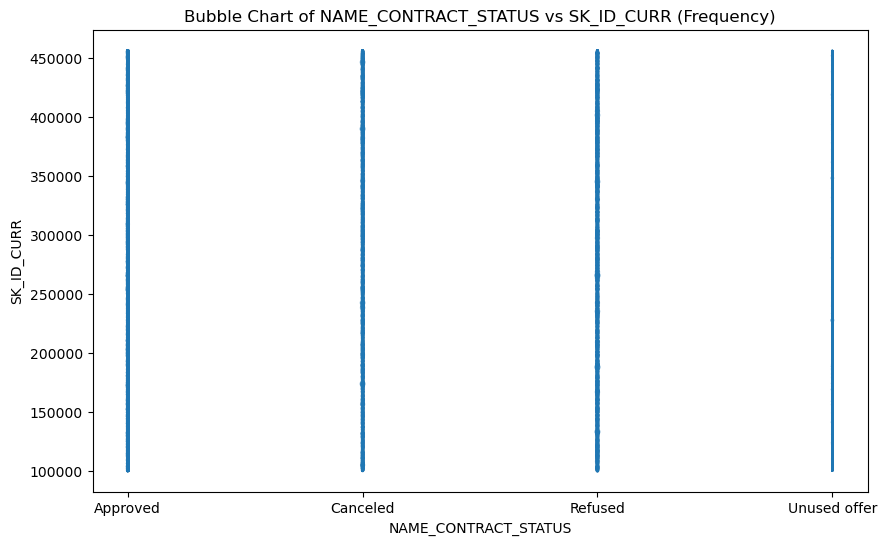

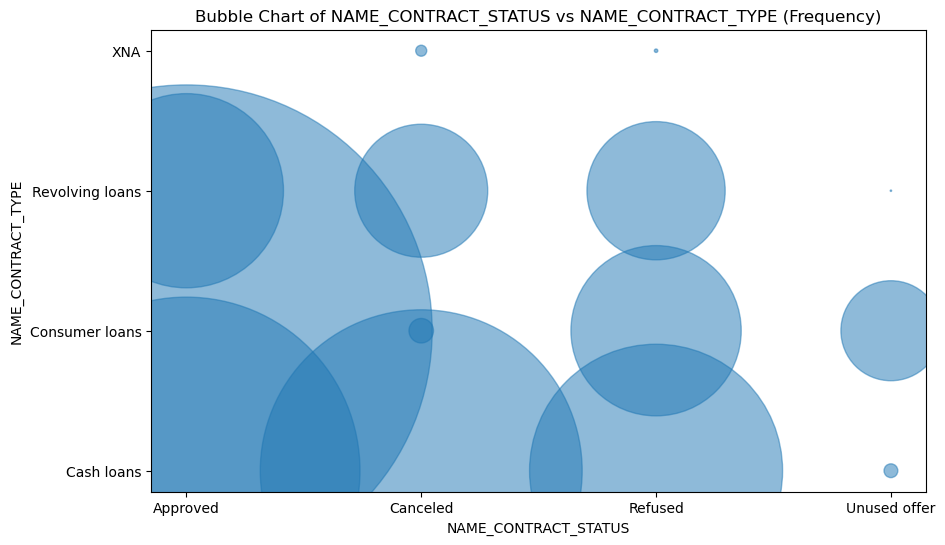

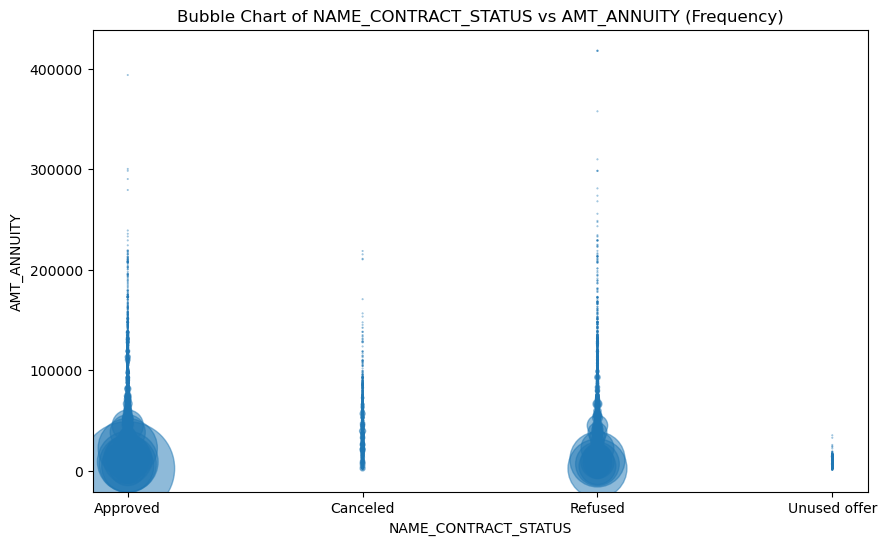

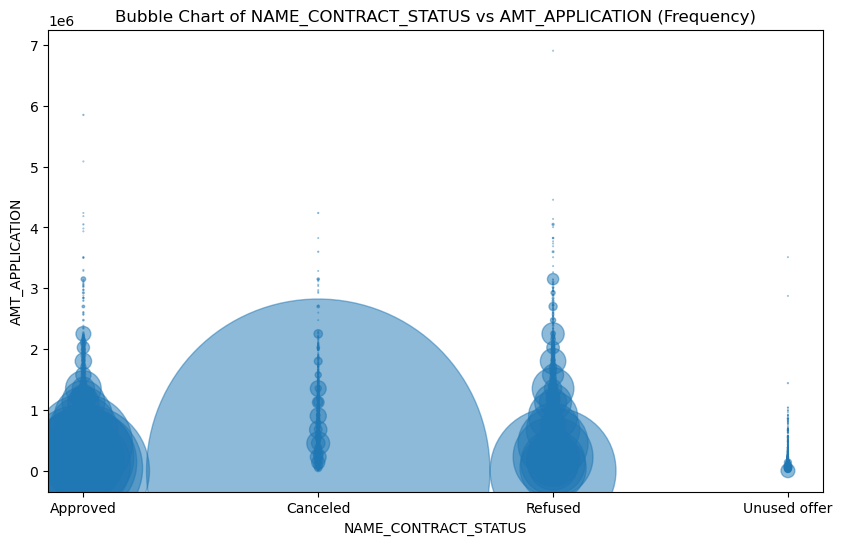

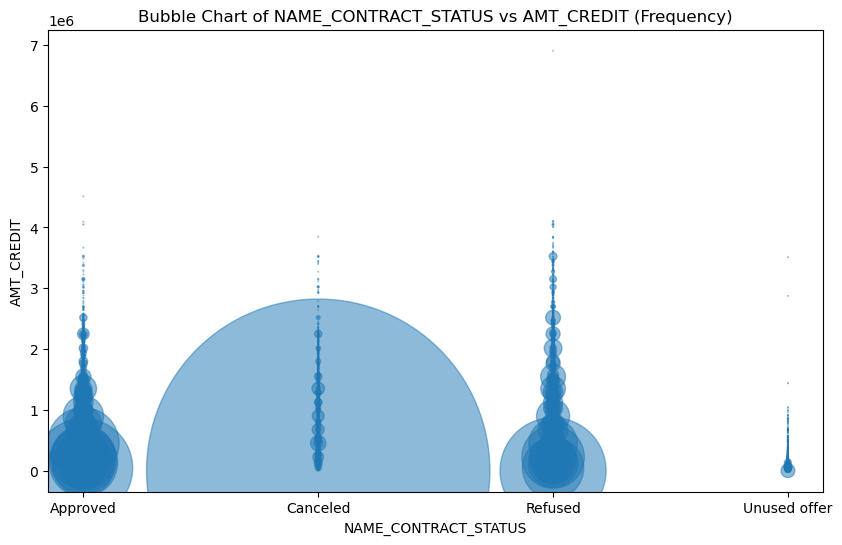

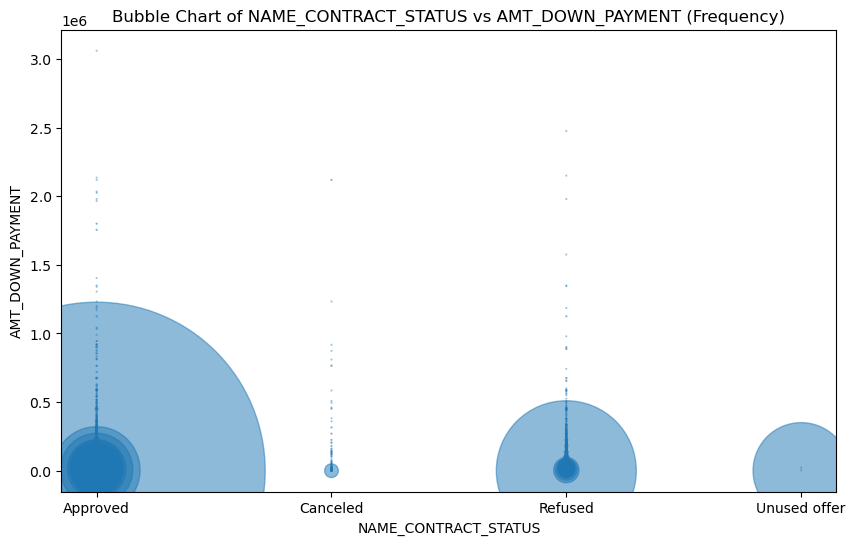

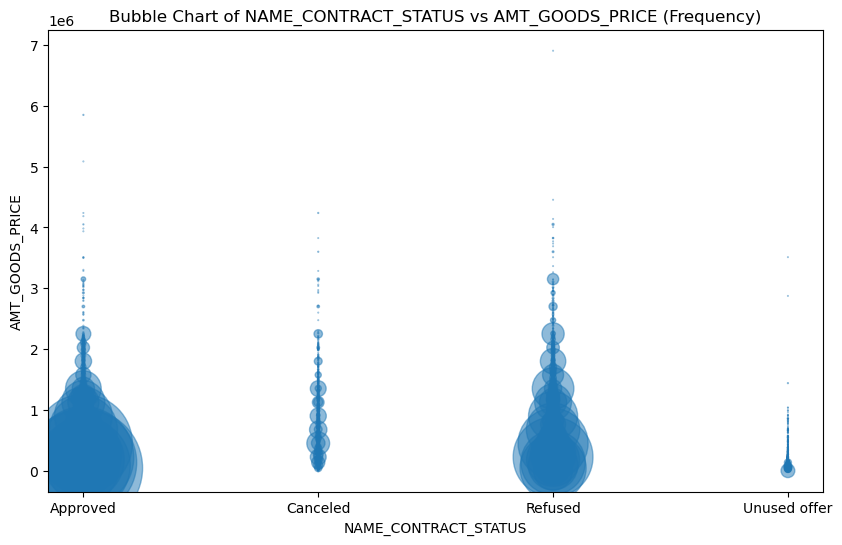

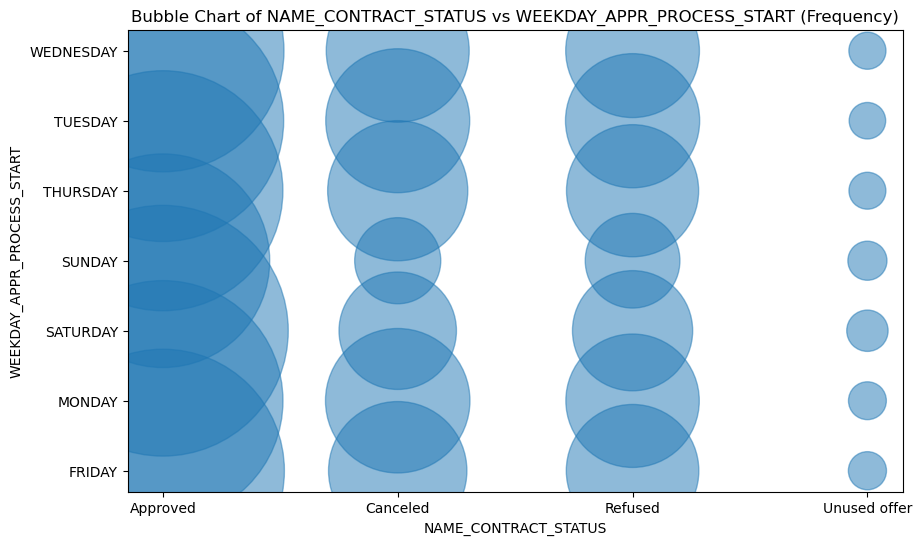

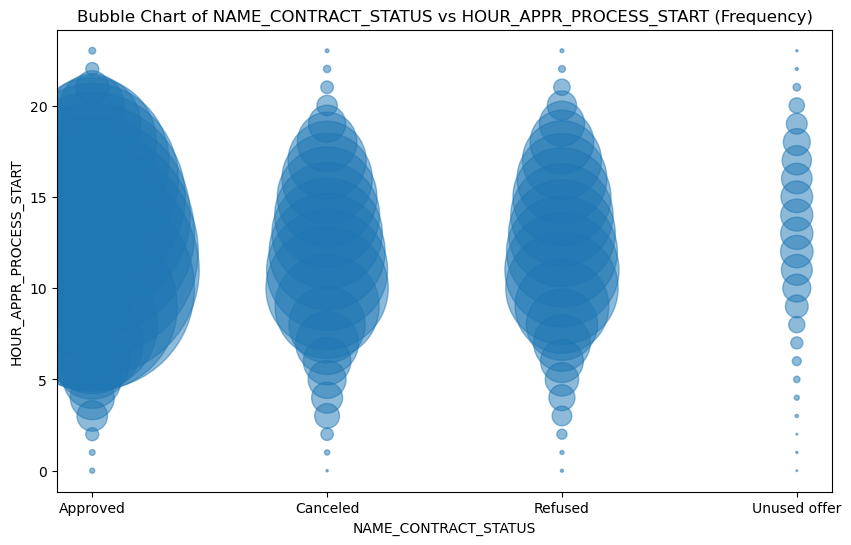

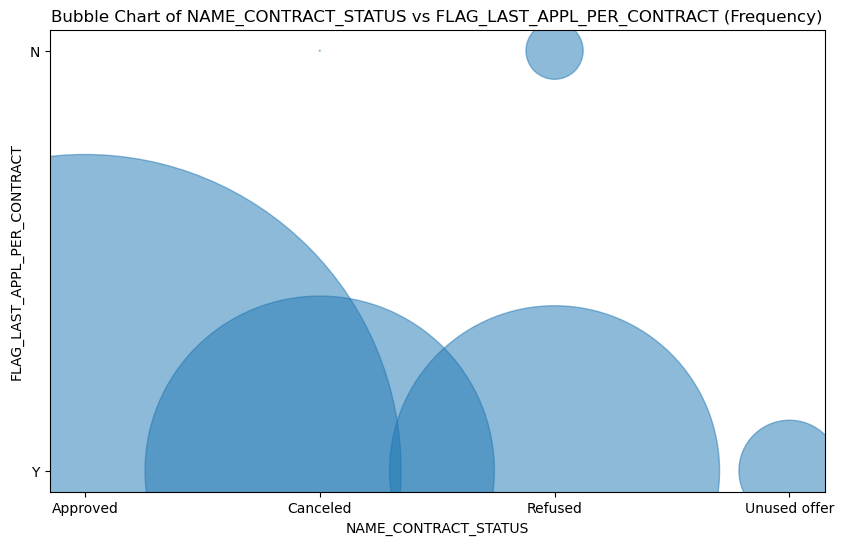

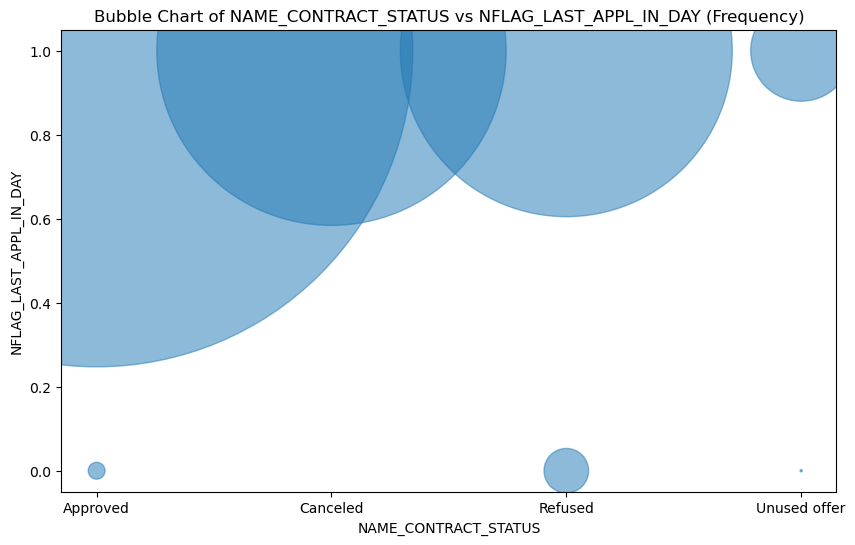

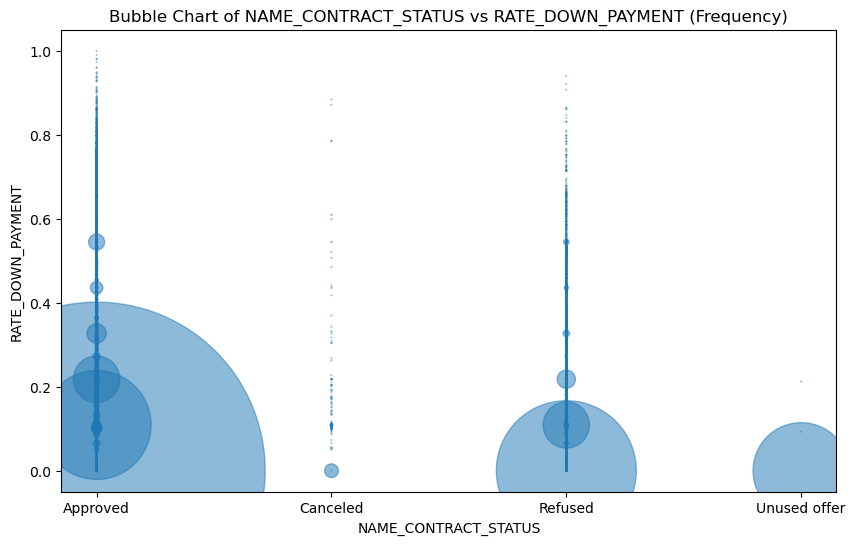

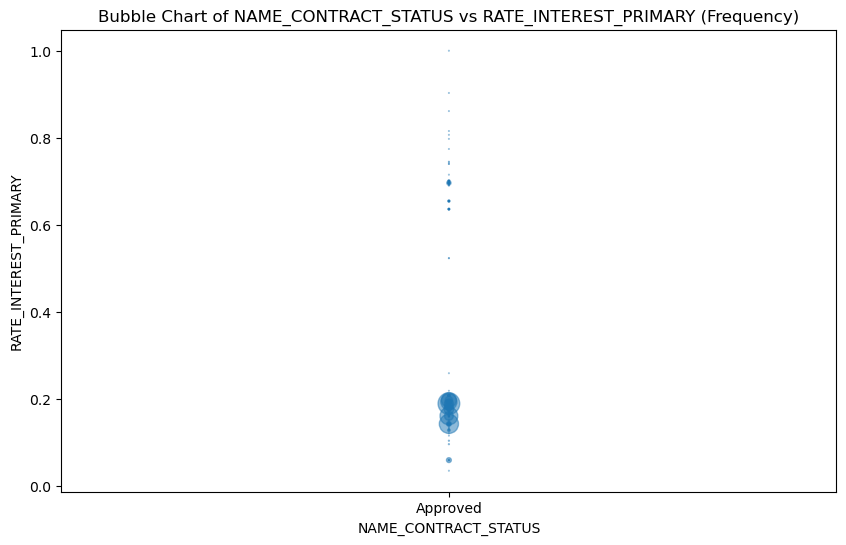

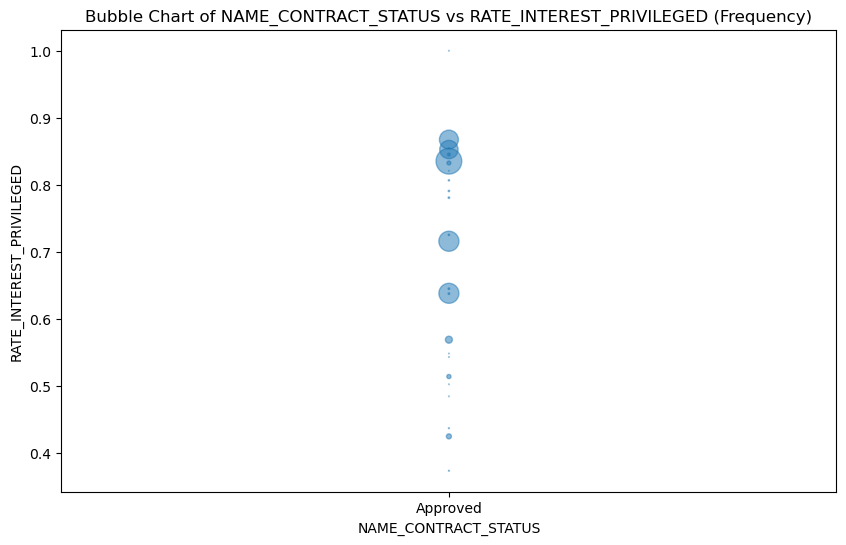

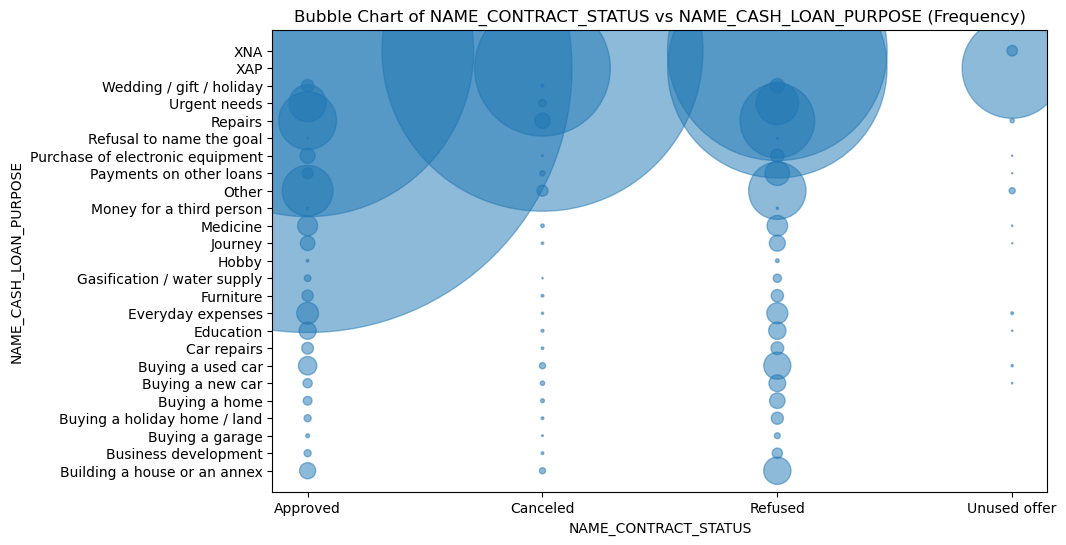

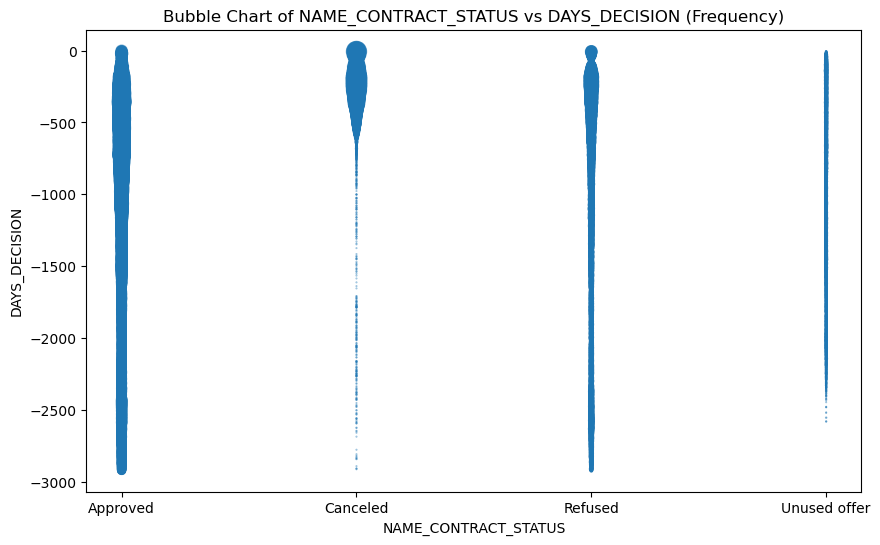

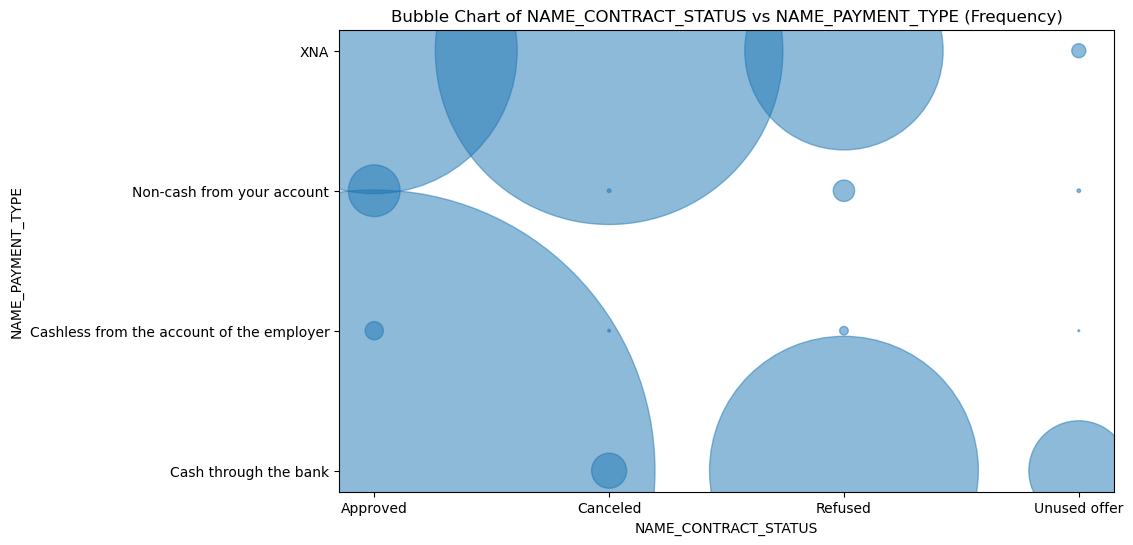

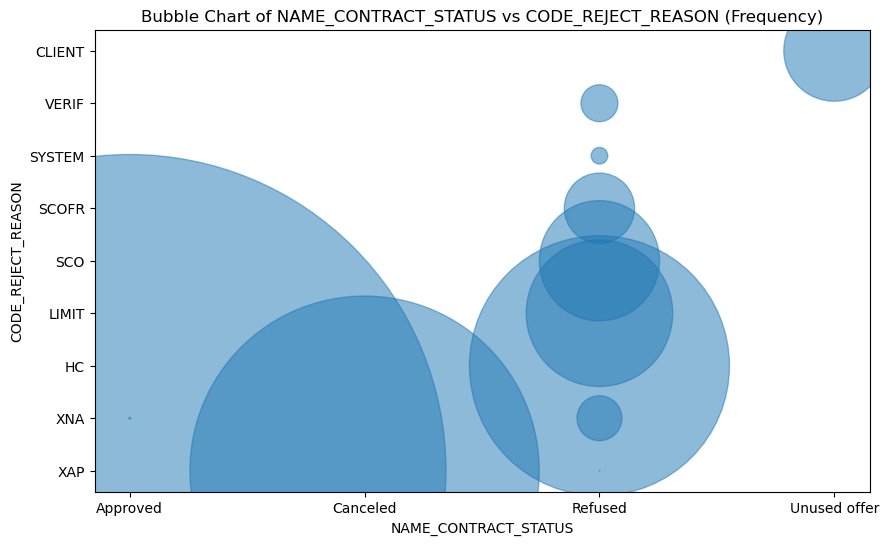

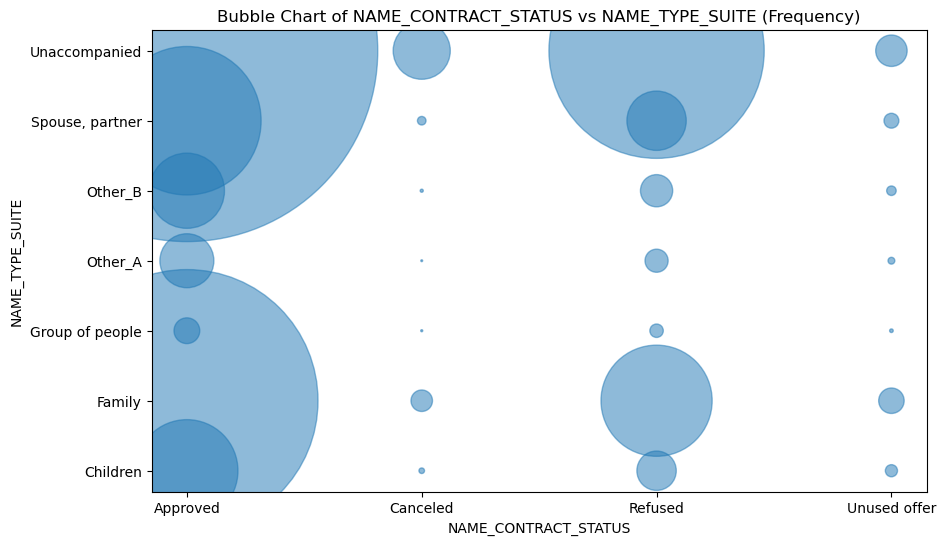

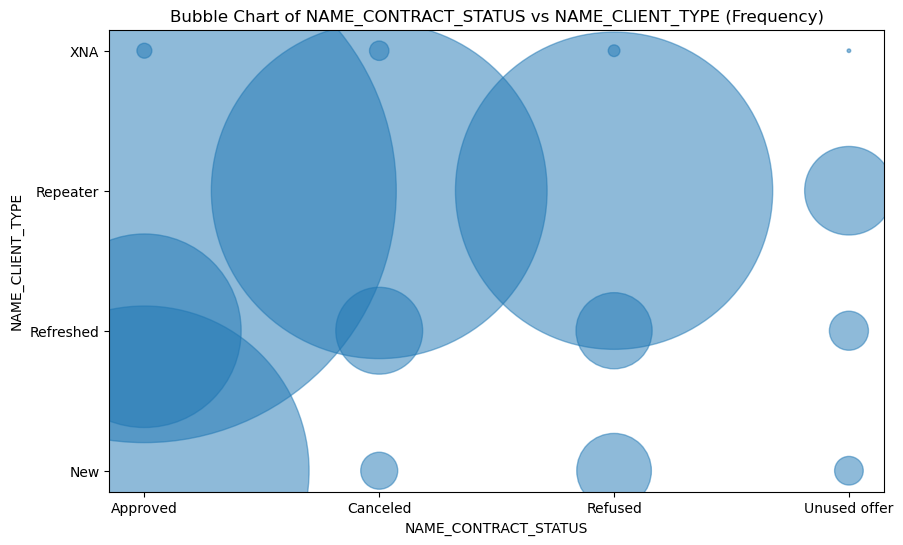

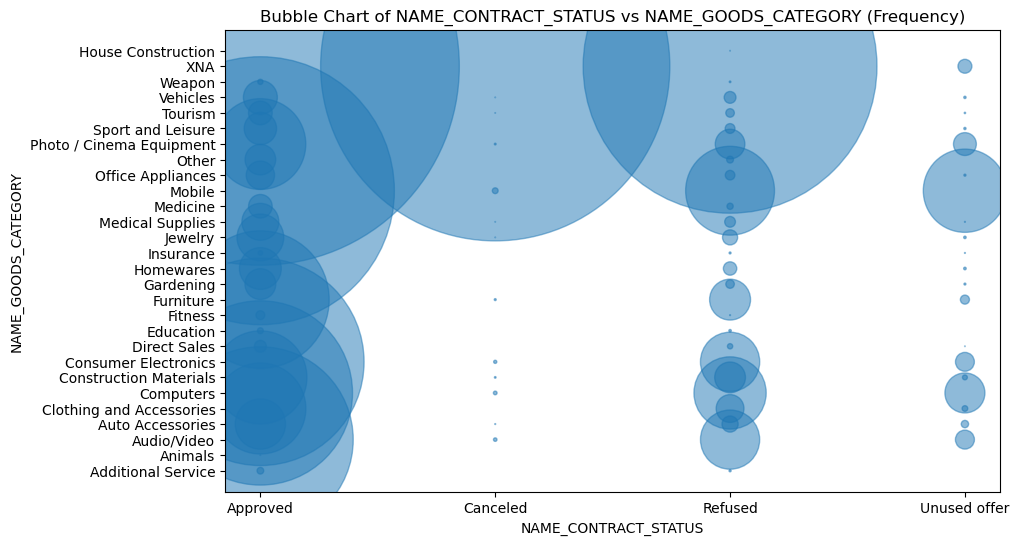

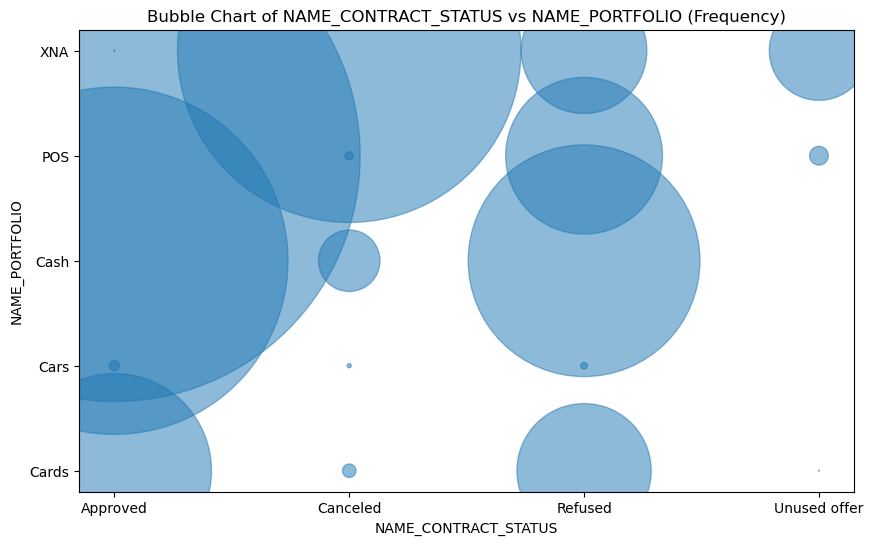

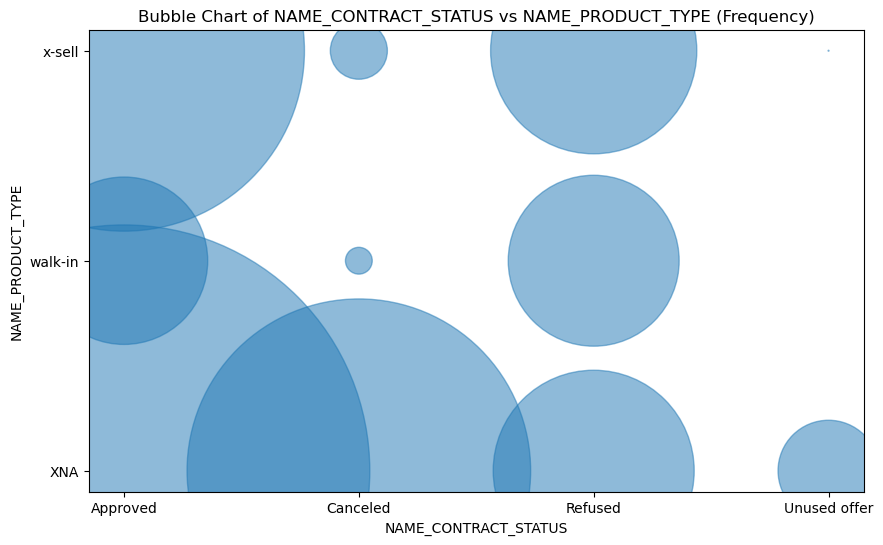

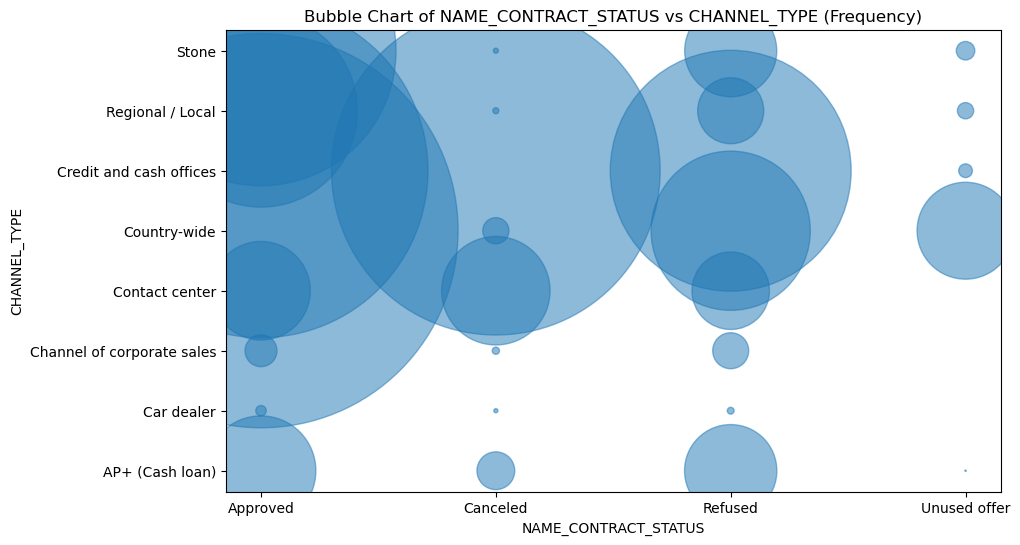

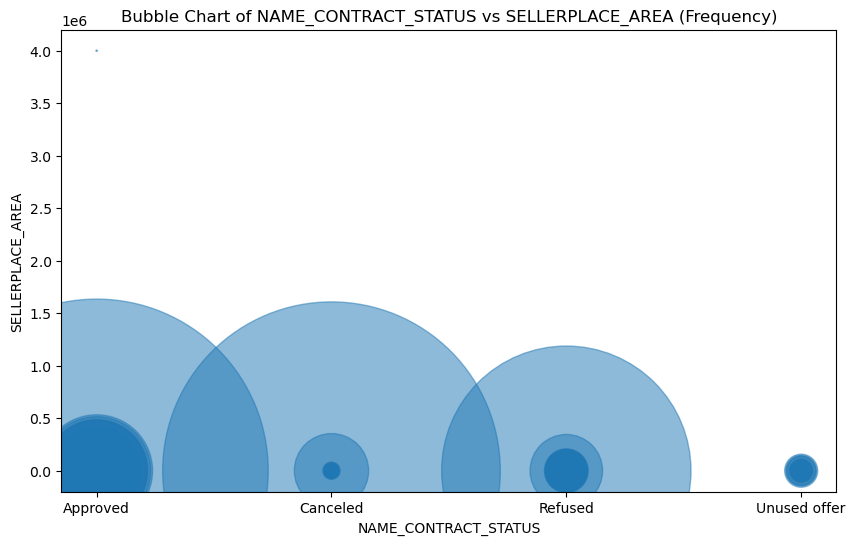

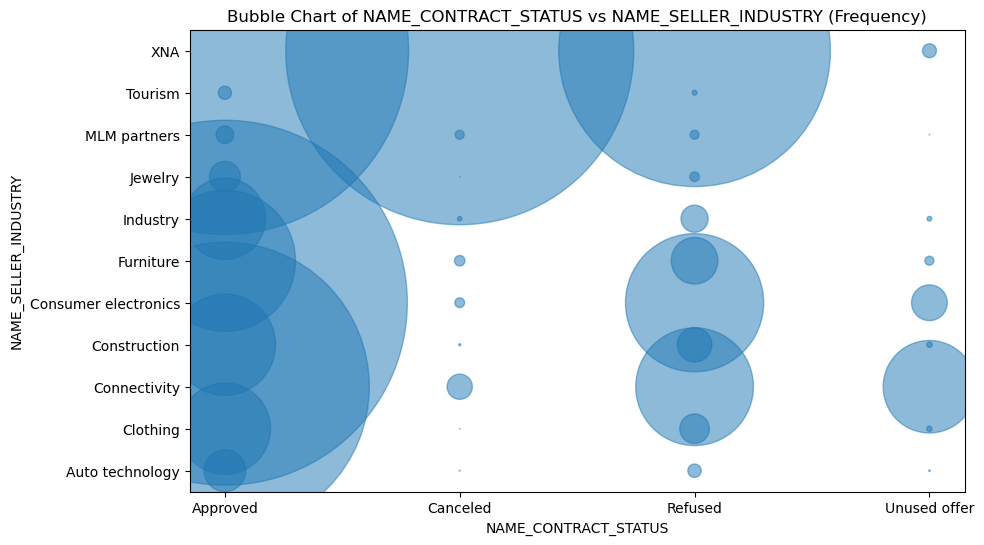

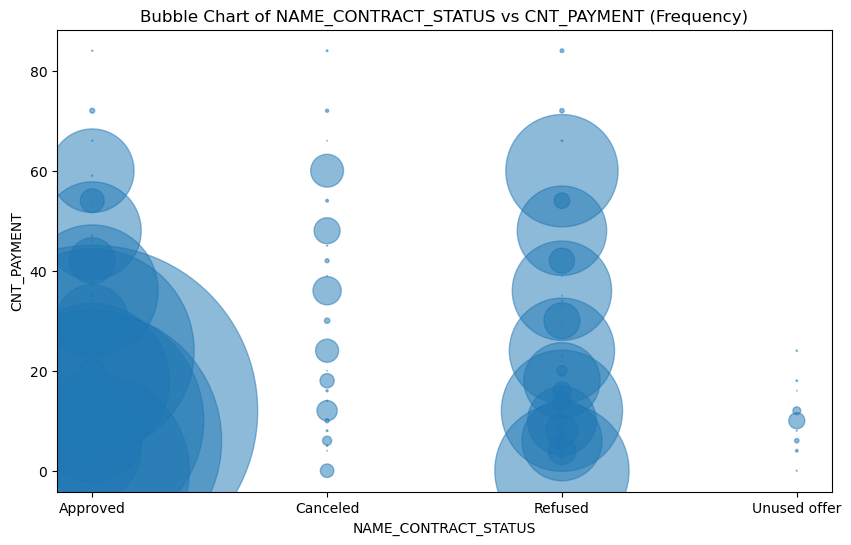

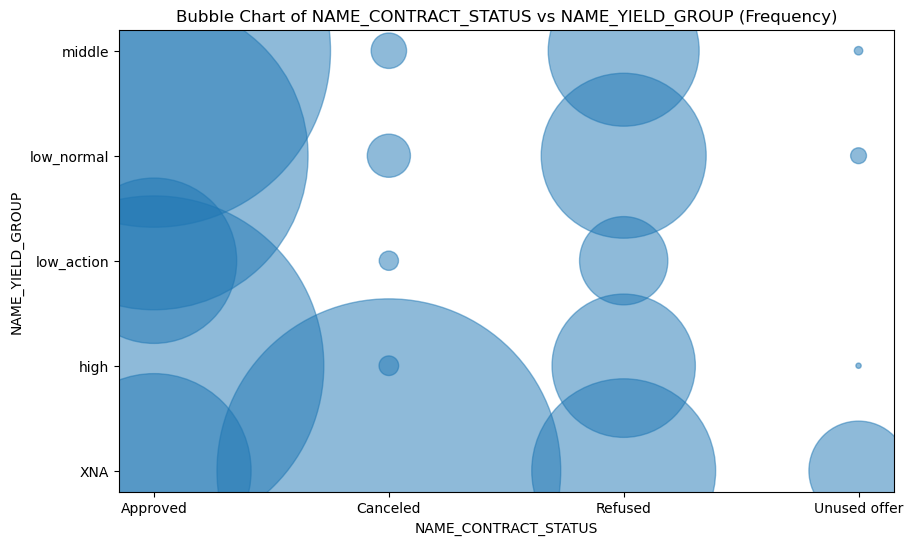

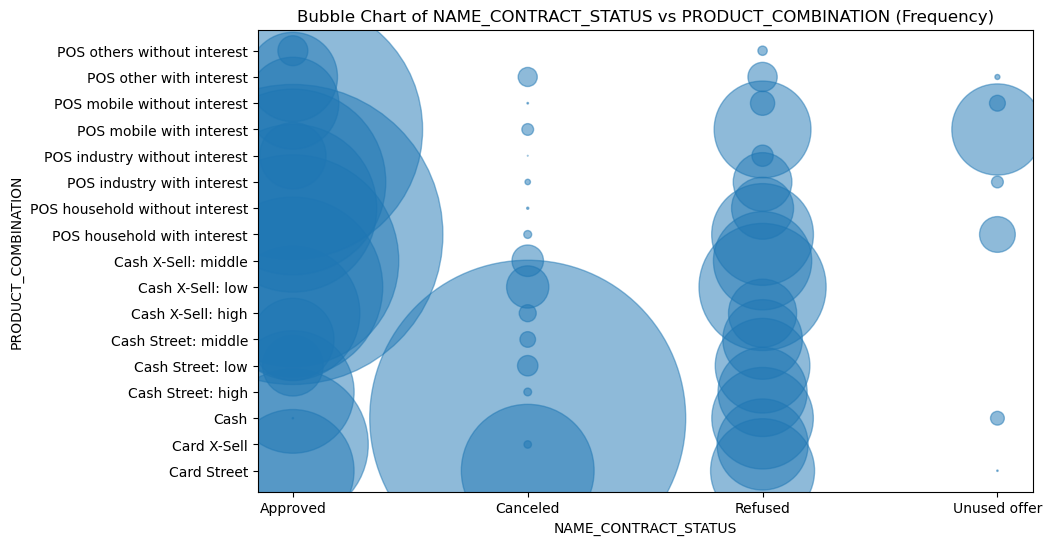

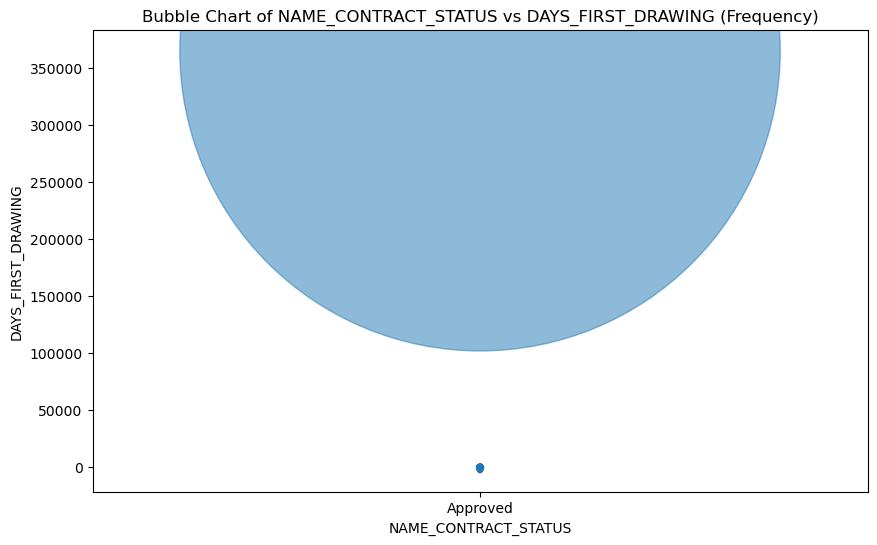

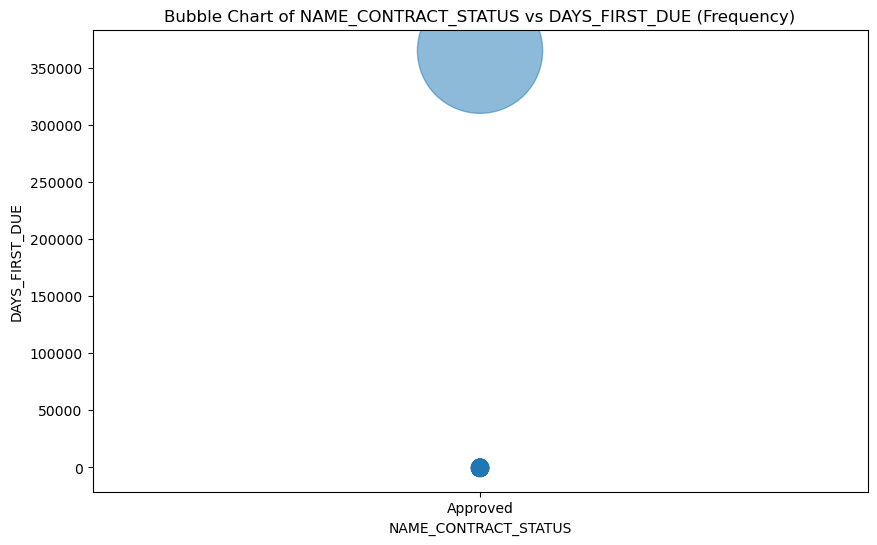

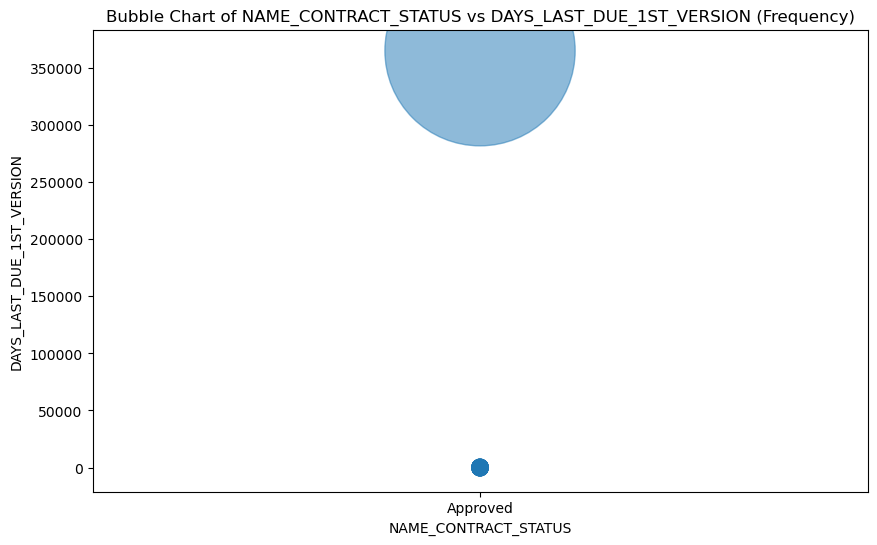

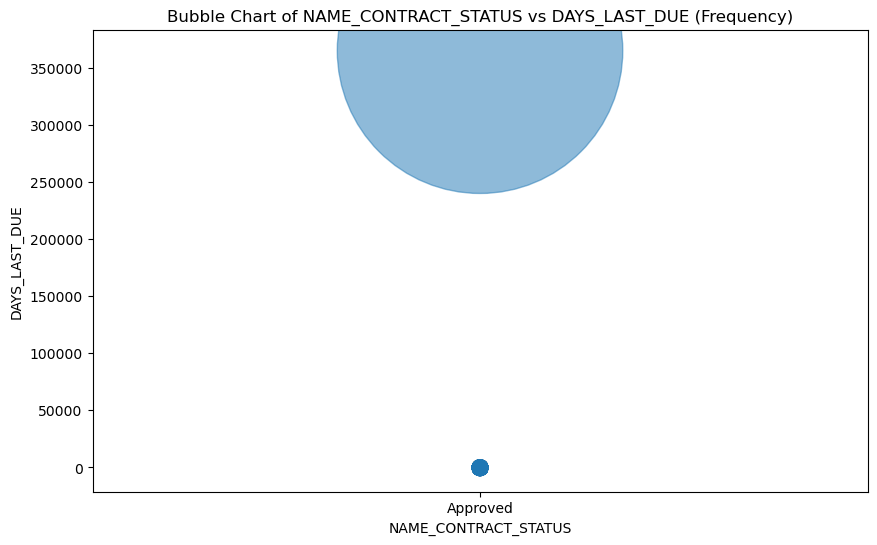

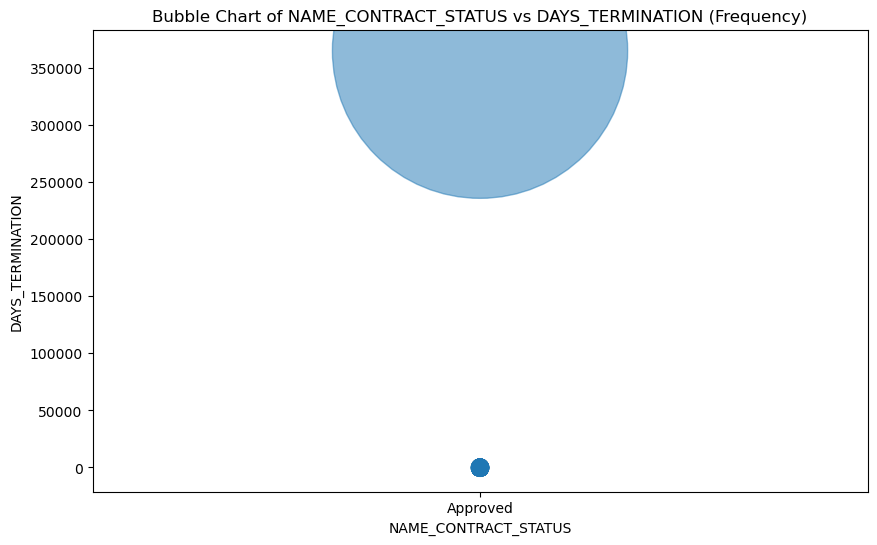

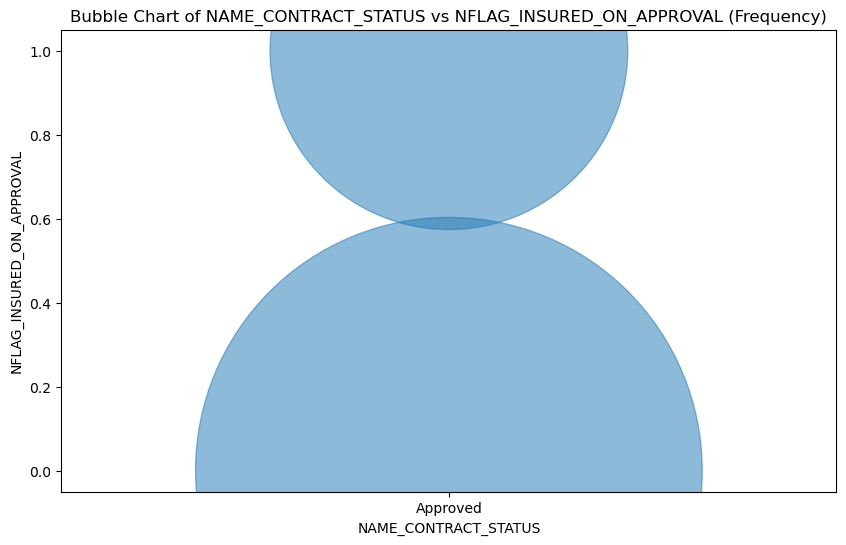

In [6]:
columns = prev_data.columns.tolist()
columns.remove('NAME_CONTRACT_STATUS')  # Exclude 'NAME_CONTRACT_STATUS'

for col in columns:
    bubble_data = prev_data.groupby(['NAME_CONTRACT_STATUS', col]).size().reset_index(name='Frequency')
    bubble_size = bubble_data['Frequency'] * 0.2

    plt.figure(figsize=(10, 6))
    plt.scatter(bubble_data['NAME_CONTRACT_STATUS'], bubble_data[col], s=bubble_size, alpha=0.5)

    plt.xlabel('NAME_CONTRACT_STATUS')
    plt.ylabel(col)
    plt.title(f'Bubble Chart of NAME_CONTRACT_STATUS vs {col} (Frequency)')
    plt.show()

From these bubble charts we can conclude multiple things, firstly its visible that some features only have existing values if its from an ID which has an approved status. That means these wouldn't be usefull in future predictions as these are only based of approved status.

Looking at the charts we can chose a list of column which are interesting to do more research for.
these are the following columns:
- AMT_annuity
- AMT_APPLICATION
- AMT_CREDIT
- AMT_DOWN_PAYMENT
- AMT_GOODS_PRICE
- NAME_CLIENT_TYPE
- CNT_PAYMENT
    
    
But Before we continue we will also the correlation between our chosen features aswell as al the other columns just to check if we might have missed something

In [7]:
# before we check the correlation between these columns we must transform some string values to floats
# use sklearn's preprocessing labelencoder to transform the label to corresponding ints
encoder = LabelEncoder()
# name client type
prev_data['NAME_CLIENT_TYPE'] = encoder.fit_transform(prev_data['NAME_CLIENT_TYPE'])
target_copy = encoder.fit_transform(prev_data['NAME_CONTRACT_STATUS'])


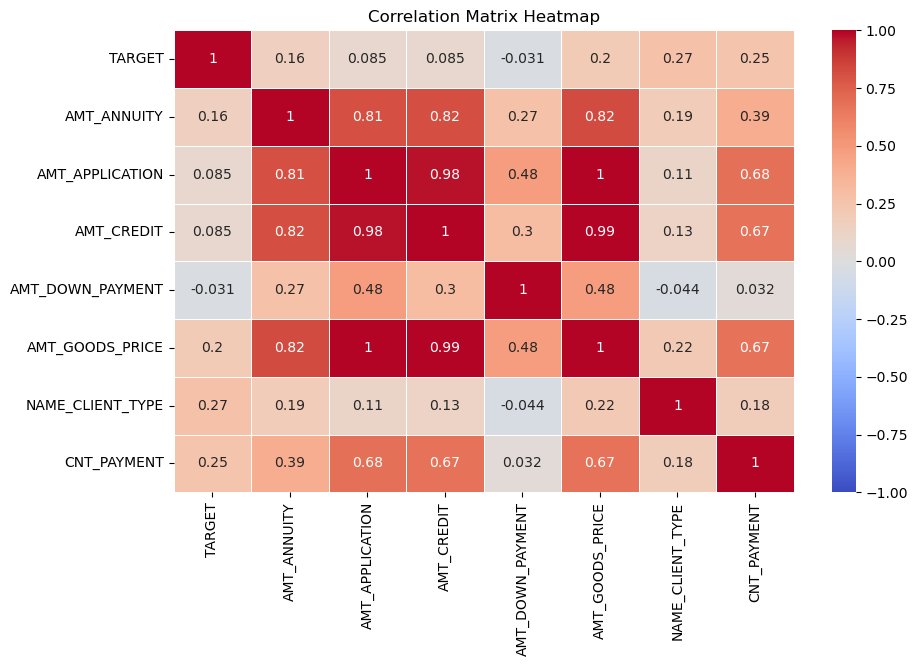

In [8]:
# Create a new DataFrame with 'target_copy' and selected columns
possible_columns = prev_data[['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'NAME_CLIENT_TYPE', 'CNT_PAYMENT']].copy()
possible_columns['TARGET'] = target_copy

# Move the 'TARGET' column to the front
possible_columns = possible_columns[['TARGET'] + [col for col in possible_columns if col != 'TARGET']]


# Calculate the correlation matrix
correlation_matrix = possible_columns.corr()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',vmin = -1, vmax = 1, linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

For each 10 columns we will make a correlation matrix including the target.
to do this we make a copy of the prev_data so we can adjust the type of the target

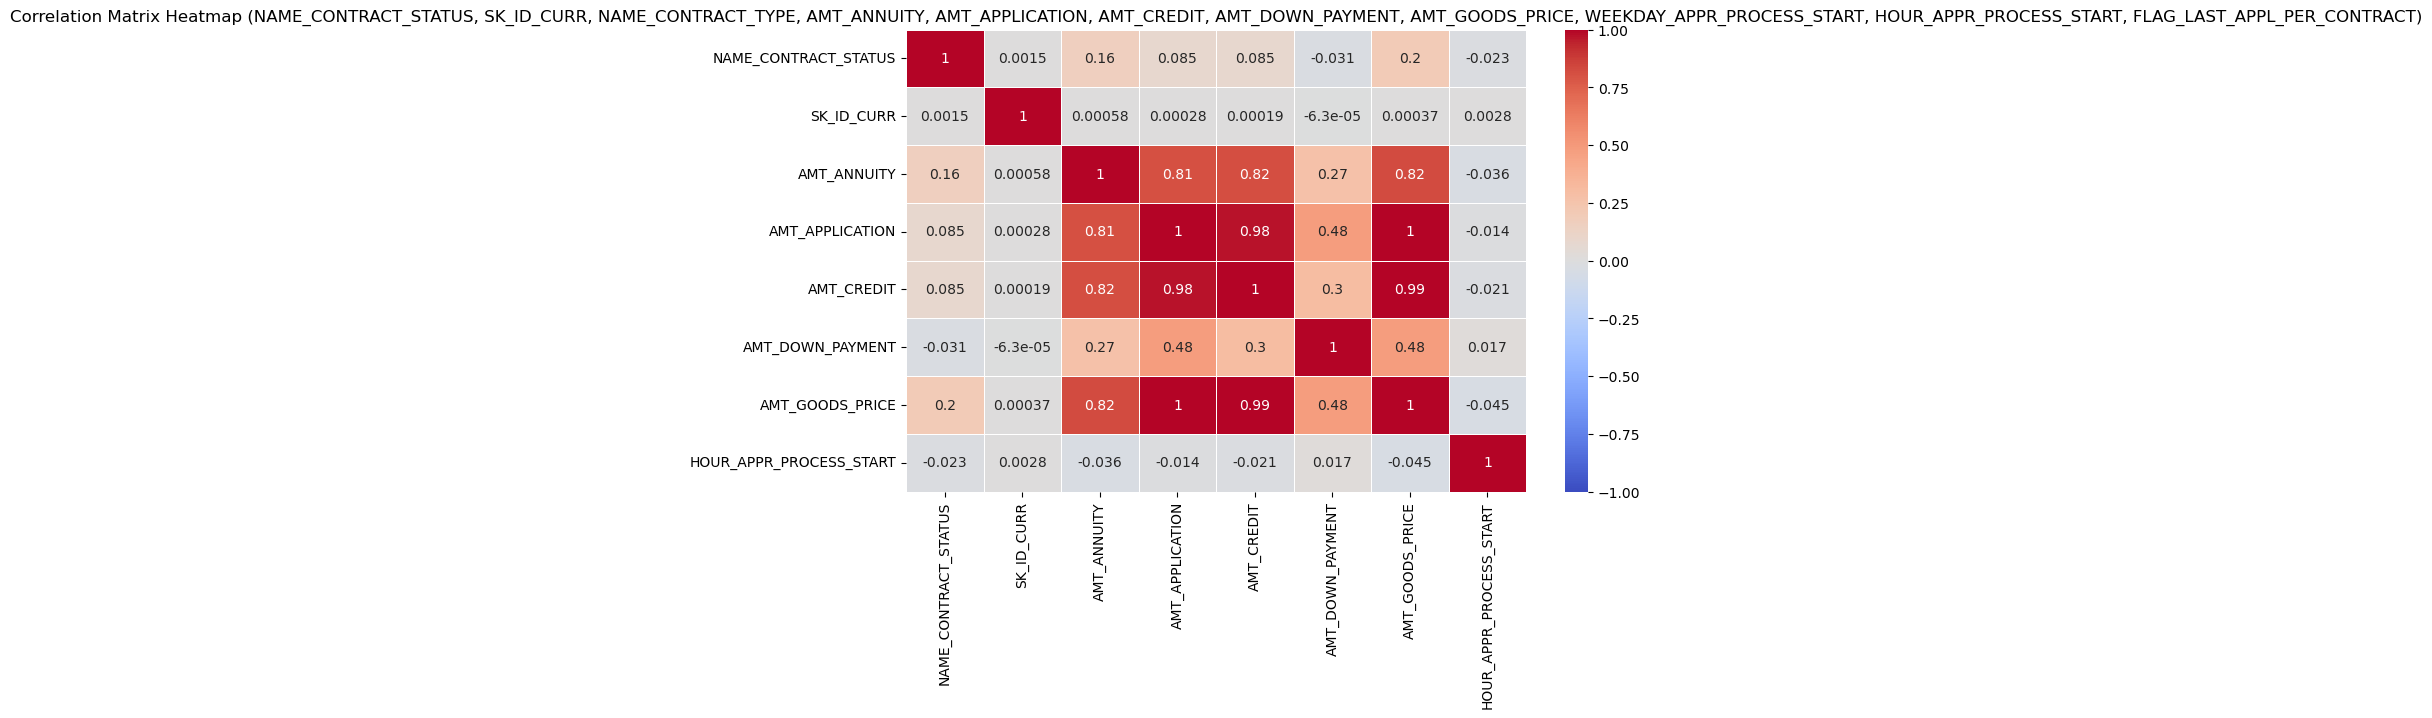

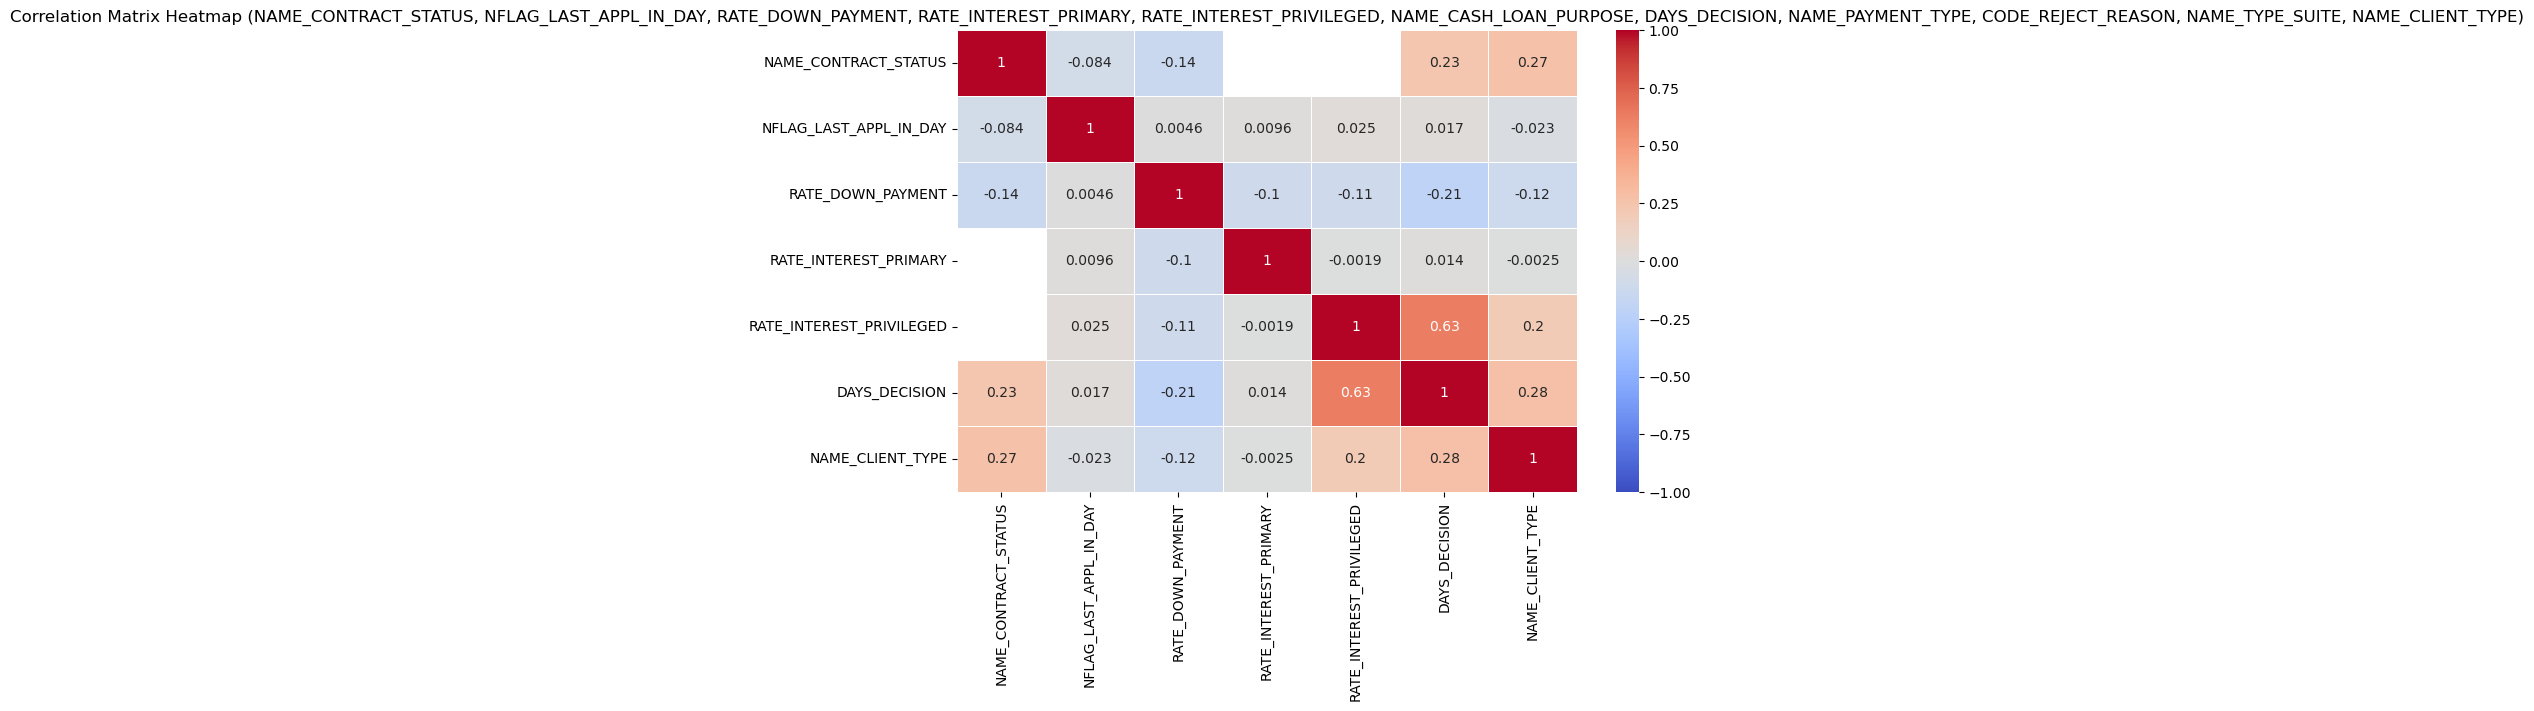

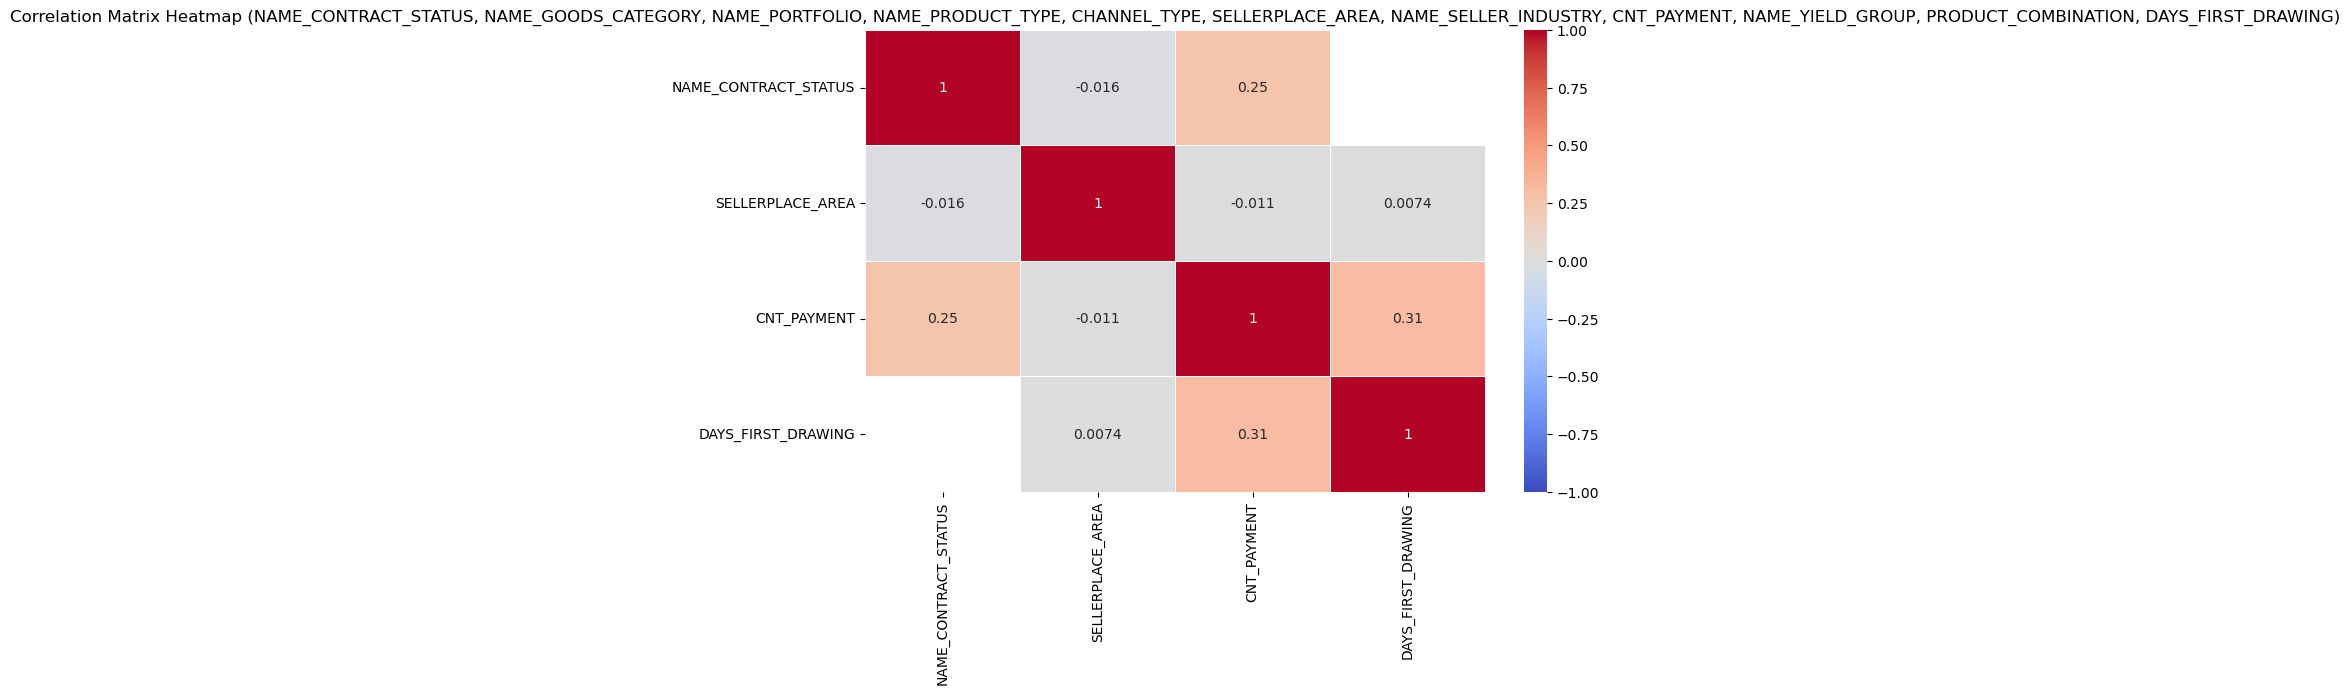

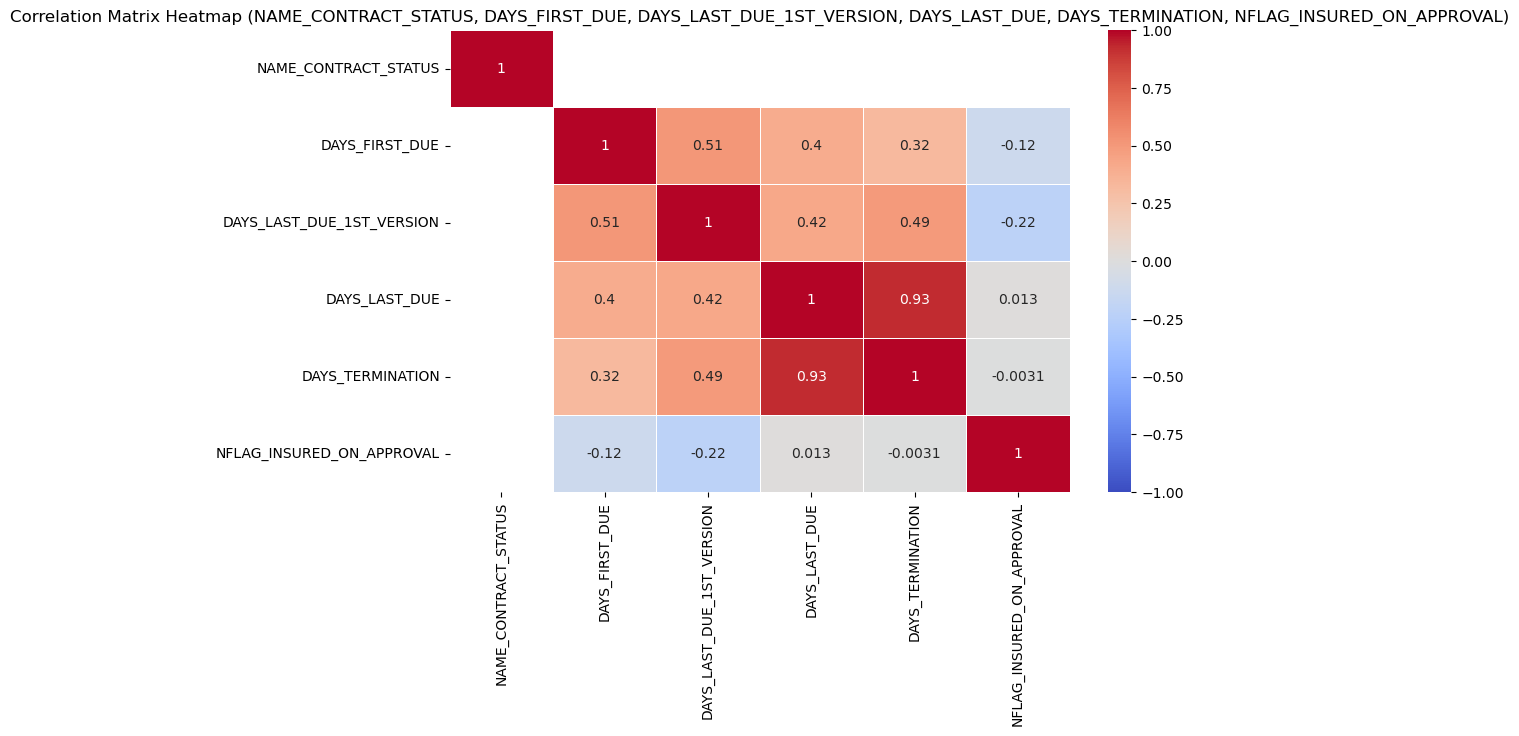

In [9]:
analyse_data = prev_data

analyse_data['NAME_CONTRACT_STATUS'] = encoder.fit_transform(analyse_data['NAME_CONTRACT_STATUS'])

# Define the number of columns in each group
columns_per_group = 10

# Get the list of column names (excluding 'NAME_CONTRACT_STATUS')
column_names = analyse_data.columns.tolist()
column_names.remove('NAME_CONTRACT_STATUS')

# Iterate through the columns in groups of 10
for i in range(0, len(column_names), columns_per_group):
    group = ['NAME_CONTRACT_STATUS'] + column_names[i:i + columns_per_group]
    
    # Select the columns for the current group
    columns_to_include = prev_data[group]
    
    # Calculate the correlation matrix
    correlation_matrix = columns_to_include.corr()

    # Create a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',vmin = -1, vmax = 1, linewidths=0.5)
    plt.title(f'Correlation Matrix Heatmap ({", ".join(group)})')
    plt.show()


A detail we can see in each correlation matrix is that some columns have no score compared with the target. This is because some Columns only have values if the target is approved and consists of data based on it being approved, for example in how many days the approved loan has its first payment due

### Final preparation of the chosen features

Now that we have insight in all the data we came to a conclusion that these will be the most usefull features:
- NAME_CLIENT_TYPE
- CNT_PAYMENT
- DAYS_DECISION
- AMT_GOODS_PRICE

Before we continue with these features lets take a closer look to these features and see if we can possibly Clean up the NAN-values.

In [10]:
# beschrijving ophalen van interesante features
columns = prev_data[['NAME_CLIENT_TYPE','CNT_PAYMENT','DAYS_DECISION', 'AMT_GOODS_PRICE']]
for column in columns:
    info = col_desc.loc[column]['Description']
    print(info)

Was the client old or new client when applying for the previous application
Term of previous credit at application of the previous application
Relative to current application when was the decision about previous application made
Goods price of good that client asked for (if applicable) on the previous application


In [11]:
# Retreiving all nan-values and the percentage of it within the column
columns_to_check = prev_data[['NAME_CLIENT_TYPE','CNT_PAYMENT','DAYS_DECISION', 'AMT_GOODS_PRICE']]

nan_count = columns_to_check.isnull().sum()

for column in columns_to_check:
    nan_count_for_column = nan_count[column]
    total_count = len(prev_data)
    nan_percentage = (nan_count_for_column / total_count) * 100
    print(f"For column: {column}, we have: {nan_count_for_column} nan values, which is {nan_percentage:.2f}% of the total.")

For column: NAME_CLIENT_TYPE, we have: 0 nan values, which is 0.00% of the total.
For column: CNT_PAYMENT, we have: 372230 nan values, which is 22.29% of the total.
For column: DAYS_DECISION, we have: 0 nan values, which is 0.00% of the total.
For column: AMT_GOODS_PRICE, we have: 385515 nan values, which is 23.08% of the total.


### Cleaning nan-values

after doing research to what the nan-values could mean in each column we came to the conclusion it wont be harmfull to change these to 0.

Explanation why for each column:
- CNT_PAYMENT = We can change these values to 0 because it looks at the term of previous application but for first time applications this could also be 0.

- DAYS_DECISION = We can change these values to 0 because it looks at the amount of days this person has made its last application, for first time applications me can make this to 0.

- AMT_GOODS_PRICE = This is a similair column to CNT_PAYMENT and therefor we believe these can also be adjusted to 0.

In [12]:
# Replace NaN values with 0 in the selected columns
selected_columns = ['CNT_PAYMENT', 'DAYS_DECISION','AMT_GOODS_PRICE']
prev_data[selected_columns] = prev_data[selected_columns].fillna(0)


## Baseline

Lets set up a baseline to be able to verify in the future if our models will actually help.



In [13]:
#defining the baseline
count_by_status = prev_data['NAME_CONTRACT_STATUS'].value_counts()
total_len = len(prev_data)  # Use len() on the DataFrame

#gives us the amount of all values in Name_contract_status
approved_count = count_by_status.get(0, 0)

# This will give us the percentage of the baseline
baseline = ((approved_count / total_len) * 100)
print(f'The baseline is {baseline}')

The baseline is 62.074740123121956


## setup

In [14]:
# assign used values to X and y
X = prev_data[['NAME_CLIENT_TYPE', 'CNT_PAYMENT', 'DAYS_DECISION', 'AMT_GOODS_PRICE']]

y = prev_data['NAME_CONTRACT_STATUS']

# splits in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


# setup possible params
param_grid = {
    'n_neighbors': [n for n in range(2, 31, 3)],
    'weights': ['uniform', 'distance']
}

## Gridsearch

gridsearch is a functionality of sklearn that will find the best hyperparameters of our model.

In [15]:
def knn_grid_search(X, y, param_grid, cv=5):
    # initiat the model
    knn = KNeighborsClassifier()
    
    # create a grid search
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv)
    grid_search.fit(X, y)

    # get the result from the grid search
    best_params = grid_search.best_params_
    return (best_params['n_neighbors'], best_params['weights'], knn)

best_k, best_weight, knn = knn_grid_search(X, y, param_grid)
print(f"The best parameters found from the grid search were K = {best_k} and weights = {best_weight}")

The best parameters found from the grid search were K = 29 and weights = uniform


In [16]:
# Set hyper parameters
knn.set_params(n_neighbors = best_k, weights = best_weight)

# Fit het model
knn.fit(X_train,y_train)

# Ons eerste predictie
y_pred = knn.predict(X_test)
print(f"Test: {round(accuracy_score(y_test, y_pred)*100, 2)}%")

# Trainset score
y_train_pred = knn.predict(X_train)
print(f"Train: {round(accuracy_score(y_train, y_train_pred)*100, 2)}%")

Test: 81.57%
Train: 82.12%


Lets visualize our scores in a confusion matrix

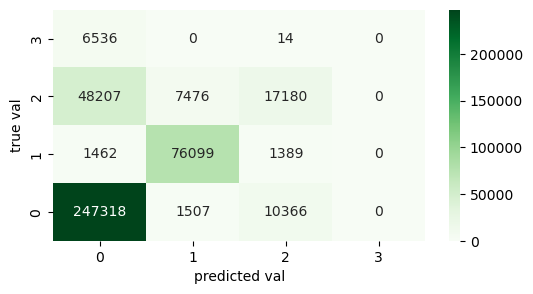

In [17]:
def draw_heatmap(test, pred):
    # Create the confusion matrix
    conf_matrix = confusion_matrix(test, pred)[::-1]

    # Set the figure size
    plt.figure(figsize=(6, 3))

    # Create a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Greens', yticklabels=['3','2','1', '0'])

    # Add labels and show
    plt.xlabel('predicted val')
    plt.ylabel('true val')
    plt.show()
    
draw_heatmap(y_test, y_pred)

### 2nd model

In the context of our research question it would also be possible to change our target values to just 0 and 1.
Therefor approved status would become 0, and every other status would be 1. Because we only want to predict if its approved or not. 
Now lets see if this would make our prediction and score better or not.

In [23]:
# Gebruik de replace-functie om 'Approved' naar 0 om te zetten en andere waarden naar 1 om te zetten
prev_data['NAME_CONTRACT_STATUS'] = prev_data['NAME_CONTRACT_STATUS'].replace({0: 0})
prev_data['NAME_CONTRACT_STATUS'] = prev_data['NAME_CONTRACT_STATUS'].replace({1: 1})
prev_data['NAME_CONTRACT_STATUS'] = prev_data['NAME_CONTRACT_STATUS'].replace({2: 1})
prev_data['NAME_CONTRACT_STATUS'] = prev_data['NAME_CONTRACT_STATUS'].replace({3: 1})



In [19]:
#setting up.
X = prev_data[['NAME_CLIENT_TYPE', 'CNT_PAYMENT', 'DAYS_DECISION', 'AMT_GOODS_PRICE']]

y = prev_data['NAME_CONTRACT_STATUS']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


# setup possible params
param_grid = {
    'n_neighbors': [n for n in range(2, 31, 3)],
    'weights': ['uniform', 'distance']
}

In [20]:
    knn = KNeighborsClassifier()


In [21]:
# Set hyper parameters
knn.set_params(n_neighbors = best_k, weights = best_weight)

# Fit het model
knn.fit(X_train,y_train)

# Ons eerste predictie
y_pred = knn.predict(X_test)
print(f"Test: {round(accuracy_score(y_test, y_pred)*100, 2)}%")

# Trainset score
y_train_pred = knn.predict(X_train)
print(f"Train: {round(accuracy_score(y_train, y_train_pred)*100, 2)}%")

Test: 83.71%
Train: 84.28%


Lets visualize our scores in a confusion matrix

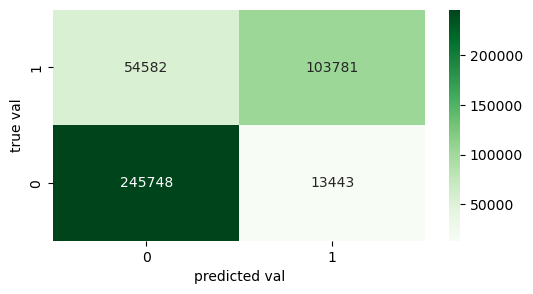

In [22]:
def draw_heatmap(test, pred):
    # Create the confusion matrix
    conf_matrix = confusion_matrix(test, pred)[::-1]

    # Set the figure size
    plt.figure(figsize=(6, 3))

    # Create a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Greens', yticklabels=['1', '0'])

    # Add labels and show
    plt.xlabel('predicted val')
    plt.ylabel('true val')
    plt.show()
    
draw_heatmap(y_test, y_pred)

# Conclusion

Using these features, doing a gridsearch and adjusting Nan-values we can see that using our model to get a better score on the baseline is certainly possible. We receive a decent score above the baseline and our overall score shows to be quite accurate with the existing and challenging data.

Besides that we can also see there is only a difference in how we set up our target values, in this case we can also predict if application offers will be unused or possibly cancelled besides being either approved or refused. As the difference isn't to big. But looking at just predicting if its approved it would still be better.